# ResNet Classification

## 0. Preparation

### 0.1. Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

### 0.2. Load Data

In [3]:
# Load CIFAR-10 dataset
(train_images,train_labels),(test_images,test_labels) = cifar10.load_data()

#sample the data
n = 10000

train_images = train_images[:n]
train_labels = train_labels[:n]

test_images = test_images[:n]
test_labels = test_labels[:n]

# Print some basic information
print(f"Number of training samples: {len(train_images)}")
print(f"Number of test samples: {len(train_labels)}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Number of training samples: 10000
Number of test samples: 10000


## 1. EDA

### 1.1. The Pictures

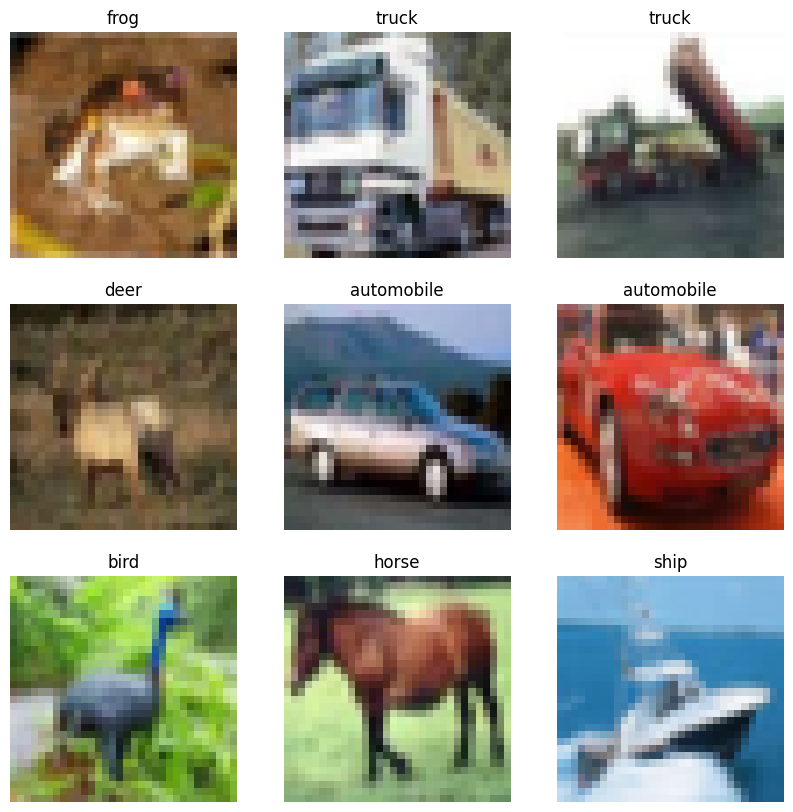

In [4]:
# Function to plot 9 sample images from the training data
def visualize_data(images, labels):
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):  # Take 9 examples
        image = images[i]
        label = labels[i][0] # Access the integer label from the array
        plt.subplot(3, 3, i+1) # building a grid to display images
        plt.imshow(image) # showing RGB images, remove cmap='gray'
        plt.title(class_names[label]) # setting a title with class name
        plt.axis('off')
    plt.show()

# Visualize the training data by calling the function
visualize_data(train_images, train_labels)


In [5]:
train_images[0].shape

(32, 32, 3)

### 1.2. Freuquency of Labels

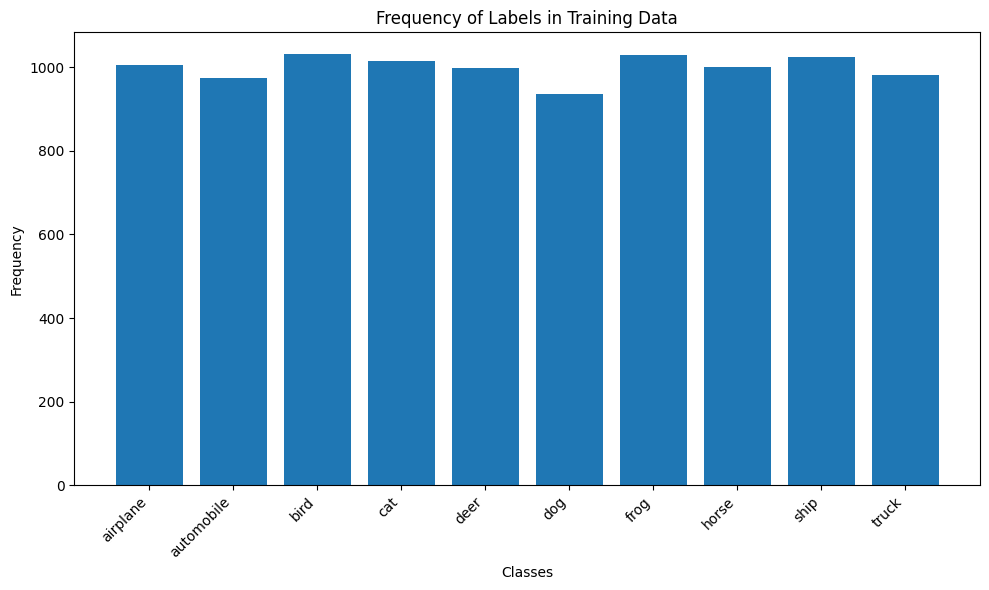

In [6]:
unique_labels, counts = np.unique(train_labels, return_counts=True)

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, tick_label=[class_names[i] for i in unique_labels])
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Frequency of Labels in Training Data')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2. Preprocessing

### 2.1. Function for Normalization and Enlarging

In [7]:
# preprocessing is run during training since it is more RAM efficient
# enlarging the pictures since ResNet is trained on 224, 224 pictures

IMAGE_SIZE = (32, 32)
  # Option 1: Bilinear (default, can be blurry)
#method = tf.image.ResizeMethod.BILINEAR
  # Option 2: Nearest Neighbor (can be blocky)
method = tf.image.ResizeMethod.NEAREST_NEIGHBOR
  # Option 3: Bicubic (often a good balance between sharpness and smoothness)
#method = tf.image.ResizeMethod.BICUBIC
  # Option 4: Lanczos3 (generally very good for detail preservation and sharpness)
#method = tf.image.ResizeMethod.LANCZOS3
  # Option 5: Lanczos5 (can be even sharper than Lanczos3, but more prone to ringing artifacts)
#method = tf.image.ResizeMethod.LANCZOS5

def preprocess_image(image, label):
  # image = tf.image.resize(image, IMAGE_SIZE, method=method)
  image = image / 255
  return image, label

### 2.2. Function for Augmentation

In [8]:
def augment_image(image, label):
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    # Random rotation (small angles)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # Random brightness
    image = tf.image.random_brightness(image, 0.2)
    # Random contrast
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, label

### 2.3. The Data Pipeline

In [9]:
# Create a tf.data pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(n)
train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

# Create a tf.test pipeline
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.map(preprocess_image).batch(64).prefetch(tf.data.AUTOTUNE)

## 3. Run Classification

### 3.1. Initialize the Model

In [10]:
# Load ResNet50 pre-trained on ImageNet (without top classification layer)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=IMAGE_SIZE + (3,) # Updated input shape to match enlarged images
    )

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### 3.2. Custom Classification Layers

In [11]:
num_classes = len(np.unique(train_labels))

# Freeze base model layers (optional - for transfer learning)
base_model.trainable = False

# Create the sequential model
model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

### 3.3. Compiling the Model

In [12]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,890 (91.01 MB)

 Trainable params: 271,178 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### 3.4. Train the Model

In [13]:
# initialize early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 92s 531ms/step - accuracy: 0.1065 - loss: 2.3926 - val_accuracy: 0.1046 - val_loss: 2.3024
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 530ms/step - accuracy: 0.1057 - loss: 2.3028 - val_accuracy: 0.1003 - val_loss: 2.3027
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 516ms/step - accuracy: 0.1079 - loss: 2.3028 - val_accuracy: 0.1006 - val_loss: 2.3027
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 513ms/step - accuracy: 0.1011 - loss: 2.3024 - val_accuracy: 0.1002 - val_loss: 2.3028
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 85s 530ms/step - accuracy: 0.0988 - loss: 2.3026 - val_accuracy: 0.1002 - val_loss: 2.3029
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 521ms/step - accuracy: 0.1010 - loss: 2.3023 - val_accuracy: 0.1008 - val_loss: 2.3027


###  3.5. Evaluation

In [14]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f'\nTest accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 254ms/step - accuracy: 0.1072 - loss: 2.3023

Test accuracy: 0.1046
Test loss: 2.3024


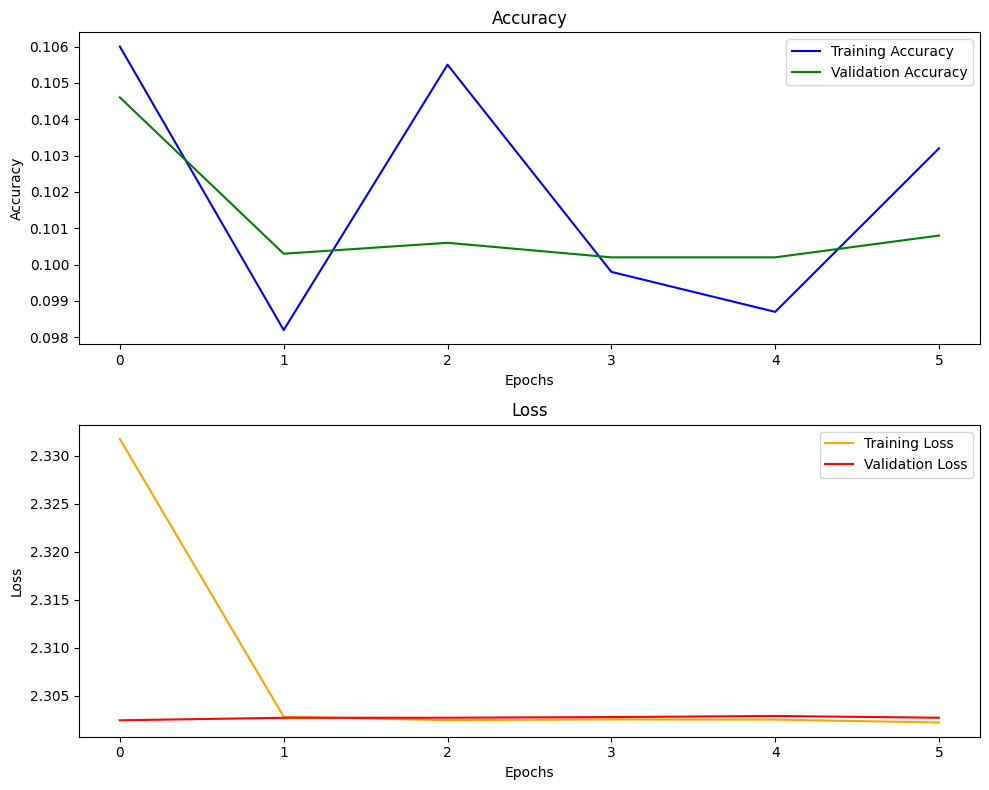

In [15]:
history_df = pd.DataFrame(history.history)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(history_df['accuracy'], label='Training Accuracy', color='blue')
ax1.plot(history_df['val_accuracy'], label='Validation Accuracy', color='green')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history_df['loss'], label='Training Loss', color='orange')
ax2.plot(history_df['val_loss'], label='Validation Loss', color='red')
ax2.set_title('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()




plt.tight_layout()
plt.show()

## 4. Fine Tuning

### 4.1. Refreeze Only Early Layers

In [16]:
# Unfreeze the base model
base_model.trainable = True
"""
# Freeze early layers, train only last few layers
for layer in base_model.layers[:-20]:
    layer.trainable = False
"""

'\n# Freeze early layers, train only last few layers\nfor layer in base_model.layers[:-20]:\n    layer.trainable = False\n'

### 4.2. Recompile

In [17]:
# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### 4.3. Train

In [18]:
# Continue training
history_fine = model.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)]
)

# Save the model
model.save('resnet50_model.h5')

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 775s 5s/step - accuracy: 0.1285 - loss: 2.5638 - val_accuracy: 0.1000 - val_loss: 8.5909
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 753s 5s/step - accuracy: 0.2342 - loss: 2.1153 - val_accuracy: 0.0999 - val_loss: 4.5554
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 741s 5s/step - accuracy: 0.3519 - loss: 1.8512 - val_accuracy: 0.1123 - val_loss: 2.5259
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 729s 5s/step - accuracy: 0.4300 - loss: 1.6242 - val_accuracy: 0.1933 - val_loss: 2.2394
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 775s 5s/step - accuracy: 0.4680 - loss: 1.5153 - val_accuracy: 0.3019 - val_loss: 2.0052
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 753s 5s/step - accuracy: 0.5179 - loss: 1.4000 - val_accuracy: 0.4966 - val_loss: 1.4659
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 810s 5s/step - accuracy: 0.5564 - loss: 1.3062 - val_accuracy: 0.5939 - val_loss: 1.2016
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 741s 5s/step - accuracy: 0.5934 - loss: 1.2103 - val_accu

### 4.4. Evaluation

In [19]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f'\nTest accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 267ms/step - accuracy: 0.6904 - loss: 0.9567

Test accuracy: 0.6844
Test loss: 0.9763


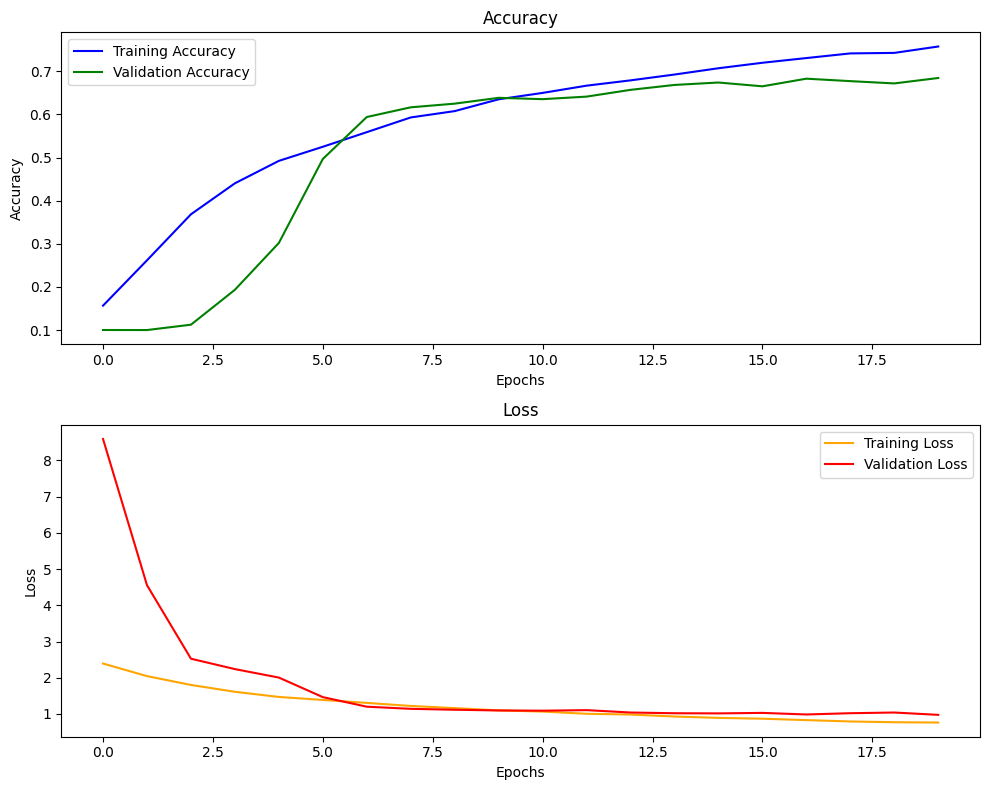

In [20]:
history_df = pd.DataFrame(history_fine.history)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(history_df['accuracy'], label='Training Accuracy', color='blue')
ax1.plot(history_df['val_accuracy'], label='Validation Accuracy', color='green')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history_df['loss'], label='Training Loss', color='orange')
ax2.plot(history_df['val_loss'], label='Validation Loss', color='red')
ax2.set_title('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()




plt.tight_layout()
plt.show()